In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('hmda_final.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'OCCUPANCY', 'AMNT', 'ACTION', 'MA', 'STATE', 'APP_ETH',
       'APP_SEX', 'APP_INC', 'HOEPA', 'LIENSTATUS', 'POP', 'MINPOP', 'MED_INC',
       'TCT2MSA', 'OWNOCC', 'OWNOCC4', 'LOAN_TYPE_1.0', 'LOAN_TYPE_2.0',
       'LOAN_TYPE_3.0', 'LOAN_TYPE_4.0', 'LOAN_TYPE_nan', 'PROP_TYPE_1.0',
       'PROP_TYPE_2.0', 'PROP_TYPE_3.0', 'PROP_TYPE_nan', 'PURPOSE_1.0',
       'PURPOSE_2.0', 'PURPOSE_3.0', 'PURPOSE_nan', 'PURCHTYPE_0.0',
       'PURCHTYPE_1.0', 'PURCHTYPE_2.0', 'PURCHTYPE_3.0', 'PURCHTYPE_4.0',
       'PURCHTYPE_5.0', 'PURCHTYPE_6.0', 'PURCHTYPE_7.0', 'PURCHTYPE_8.0',
       'PURCHTYPE_9.0', 'PURCHTYPE_nan', 'APP_RACE1_1.0', 'APP_RACE1_2.0',
       'APP_RACE1_3.0', 'APP_RACE1_4.0', 'APP_RACE1_5.0', 'APP_RACE1_nan',
       'COAP_RACE1_1.0', 'COAP_RACE1_2.0', 'COAP_RACE1_3.0', 'COAP_RACE1_4.0',
       'COAP_RACE1_5.0', 'COAP_RACE1_8.0', 'COAP_RACE1_nan', 'COAP_SEX_1.0',
       'COAP_SEX_2.0', 'COAP_SEX_5.0', 'COAP_SEX_nan', 'COAPP_ETH_1.0',
       'COAPP_ETH_2.0', 

In [4]:
df.drop(columns='Unnamed: 0',inplace = True)

In [5]:
df.drop(columns=['LOAN_TYPE_nan','PROP_TYPE_nan','PURPOSE_nan','PURCHTYPE_nan','APP_RACE1_nan','COAP_RACE1_nan','COAPP_ETH_nan','COAP_SEX_nan'],inplace = True)

In [6]:
#df.drop(columns=['APP_RACE1_1.0','APP_RACE1_2.0','APP_RACE1_3.0','APP_RACE1_4.0','APP_RACE1_5.0'],inplace = True)

In [7]:
df = pd.get_dummies(df,columns=['LIENSTATUS'])

In [8]:
df['female'] = 0

In [9]:
df.female = (df.APP_SEX == 0) * 1   

In [10]:
df['Non_white'] = 0

In [11]:
df.Non_white = (df['APP_RACE1_5.0'] == 0) * 1    # white:0,  non_white:1

In [12]:
df.drop(columns = ['APP_SEX'],inplace = True)

In [13]:
df["APP_INC"] = pd.to_numeric(df["APP_INC"], errors='coerce')

In [14]:
df = df.dropna(subset = ['APP_INC'])

In [15]:
len(df)

6809786

In [16]:
df = df.sample(frac=0.01)

In [17]:
len(df)

68098

# Themis-mil

In [18]:
from themis_ml import datasets
from themis_ml.datasets.german_credit_data_map import \
    preprocess_german_credit_data
from themis_ml.metrics import mean_difference, normalized_mean_difference, \
    mean_confidence_interval

## Measure Bias

### Target variable: ACTION

In [19]:
Action = df.ACTION

In [20]:
Action.value_counts()

1    52850
0    15248
Name: ACTION, dtype: int64

### Protected class: sex

Advantaged group: men
Disadvantaged group: women

In [21]:
female = df.female

In [22]:
female.value_counts()

0    47459
1    20639
Name: female, dtype: int64

In [23]:
def report_metric(metric, mean_diff, lower, upper):
    print("{metric}: {md:0.02f} - 95% CI [{lower:0.02f}, {upper:0.02f}]"
          .format(metric=metric, md=mean_diff, lower=lower, upper=upper))

report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(Action, female)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(Action, female)))

mean difference: 3.94 - 95% CI [3.26, 4.62]
normalized mean difference: 5.33 - 95% CI [4.65, 6.01]


### Protected class: ethnics

Advantaged group: Non-hispanic Disadvantaged group: hispanic

In [24]:
hispanic = df.APP_ETH

In [25]:
hispanic.value_counts()

0    61423
1     6675
Name: APP_ETH, dtype: int64

In [26]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(Action, hispanic)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(Action, hispanic)))

mean difference: 6.87 - 95% CI [5.81, 7.92]
normalized mean difference: 7.98 - 95% CI [6.93, 9.03]


### Protected class: Race

Advantaged group: White Disadvantaged group: all other

In [27]:
non_white = df.Non_white

In [28]:
non_white.value_counts()

0    58185
1     9913
Name: Non_white, dtype: int64

In [29]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(Action, non_white)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(Action, non_white)))

mean difference: 9.53 - 95% CI [8.65, 10.42]
normalized mean difference: 10.49 - 95% CI [9.61, 11.38]


# Establish Baseline Metrics

In [30]:
import itertools

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score)

In [31]:
df.columns

Index(['OCCUPANCY', 'AMNT', 'ACTION', 'MA', 'STATE', 'APP_ETH', 'APP_INC',
       'HOEPA', 'POP', 'MINPOP', 'MED_INC', 'TCT2MSA', 'OWNOCC', 'OWNOCC4',
       'LOAN_TYPE_1.0', 'LOAN_TYPE_2.0', 'LOAN_TYPE_3.0', 'LOAN_TYPE_4.0',
       'PROP_TYPE_1.0', 'PROP_TYPE_2.0', 'PROP_TYPE_3.0', 'PURPOSE_1.0',
       'PURPOSE_2.0', 'PURPOSE_3.0', 'PURCHTYPE_0.0', 'PURCHTYPE_1.0',
       'PURCHTYPE_2.0', 'PURCHTYPE_3.0', 'PURCHTYPE_4.0', 'PURCHTYPE_5.0',
       'PURCHTYPE_6.0', 'PURCHTYPE_7.0', 'PURCHTYPE_8.0', 'PURCHTYPE_9.0',
       'APP_RACE1_1.0', 'APP_RACE1_2.0', 'APP_RACE1_3.0', 'APP_RACE1_4.0',
       'APP_RACE1_5.0', 'COAP_RACE1_1.0', 'COAP_RACE1_2.0', 'COAP_RACE1_3.0',
       'COAP_RACE1_4.0', 'COAP_RACE1_5.0', 'COAP_RACE1_8.0', 'COAP_SEX_1.0',
       'COAP_SEX_2.0', 'COAP_SEX_5.0', 'COAPP_ETH_1.0', 'COAPP_ETH_2.0',
       'COAPP_ETH_5.0', 'LIENSTATUS_1', 'LIENSTATUS_2', 'LIENSTATUS_3',
       'female', 'Non_white'],
      dtype='object')

In [32]:
feature_set_1 = ['OCCUPANCY', 'AMNT', 'MA', 'STATE', 'APP_ETH', 'APP_INC',
       'HOEPA', 'POP', 'MINPOP', 'MED_INC', 'TCT2MSA', 'OWNOCC', 'OWNOCC4',
       'LOAN_TYPE_1.0', 'LOAN_TYPE_2.0', 'LOAN_TYPE_3.0', 'LOAN_TYPE_4.0',
       'PROP_TYPE_1.0', 'PROP_TYPE_2.0', 'PROP_TYPE_3.0', 'PURPOSE_1.0',
       'PURPOSE_2.0', 'PURPOSE_3.0', 'PURCHTYPE_0.0', 'PURCHTYPE_1.0',
       'PURCHTYPE_2.0', 'PURCHTYPE_3.0', 'PURCHTYPE_4.0', 'PURCHTYPE_5.0',
       'PURCHTYPE_6.0', 'PURCHTYPE_7.0', 'PURCHTYPE_8.0', 'PURCHTYPE_9.0',
       'APP_RACE1_1.0', 'APP_RACE1_2.0', 'APP_RACE1_3.0', 'APP_RACE1_4.0',
       'APP_RACE1_5.0', 'COAP_RACE1_1.0', 'COAP_RACE1_2.0', 'COAP_RACE1_3.0',
       'COAP_RACE1_4.0', 'COAP_RACE1_5.0', 'COAP_RACE1_8.0', 'COAP_SEX_1.0',
       'COAP_SEX_2.0', 'COAP_SEX_5.0', 'COAPP_ETH_1.0', 'COAPP_ETH_2.0',
       'COAPP_ETH_5.0', 'LIENSTATUS_1', 'LIENSTATUS_2', 'LIENSTATUS_3',
       'female']   #exclude non_white,action

In [33]:
N_SPLITS = 5
N_REPEATS = 3
RANDOM_STATE = 1000

def get_estimator_name(e):
    return "".join([x for x in str(type(e)).split(".")[-1]
                    if x.isalpha()])


def get_grid_params(grid_params_dict):
    """Get outer product of grid search parameters."""
    return [
        dict(params) for params in itertools.product(
            *[[(k, v_i) for v_i in v] for
              k, v in grid_params_dict.items()])]


def fit_with_s(estimator):
    has_relabeller = getattr(estimator, "relabeller", None) is not None
    child_estimator = getattr(estimator, "estimator", None)
    estimator_fit_with_s = getattr(estimator, "S_ON_FIT", False)
    child_estimator_fit_with_s = getattr(child_estimator, "S_ON_FIT", False)
    return has_relabeller or estimator_fit_with_s or\
        child_estimator_fit_with_s
    
    
def predict_with_s(estimator):
    estimator_pred_with_s = getattr(estimator, "S_ON_PREDICT", False)
    child_estimator = getattr(estimator, "estimator", None)
    return estimator_pred_with_s or \
        getattr(child_estimator, "S_ON_PREDICT", False)

def cross_validation_experiment(estimators, X, y, s, s_name, verbose=True):
    msg = "Training models: protected_class = %s" % s_name
    if verbose:
        print(msg)
        print("-" * len(msg))
    performance_scores = []
    # stratified groups tries to balance out y and s
    groups = [i + j for i, j in
              zip(y.astype(str), s_female.astype(str))]
    cv = RepeatedStratifiedKFold(
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        random_state=RANDOM_STATE)
    for e_name, e in estimators:
        if verbose:
            print("%s, fold:" % e_name),
        for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
            if verbose:
                print(i),
            # create train and validation fold partitions
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            s_train, s_test = s[train], s[test]

            # fit model and generate train and test predictions
            if fit_with_s(e):
                e.fit(X_train, y_train, s_train)
            else:
                e.fit(X_train, y_train)
                
            train_pred_args = (X_train, s_train) if predict_with_s(e) \
                else (X_train, )
            test_pred_args = (X_test, s_test) if predict_with_s(e) \
                else (X_test, )
                
            train_pred_prob = e.predict_proba(*train_pred_args)[:, 1]
            train_pred = e.predict(*train_pred_args)
            test_pred_prob = e.predict_proba(*test_pred_args)[:, 1]
            test_pred = e.predict(*test_pred_args)

            # train scores
            performance_scores.append([
                s_name, e_name, i, "train",
                # regular metrics
                roc_auc_score(y_train, train_pred_prob),

                # fairness metrics
                mean_difference(train_pred, s_train)[0],
            ])
            # test scores
            performance_scores.append([
                s_name, e_name, i, "test",
                # regular metrics
                roc_auc_score(y_test, test_pred_prob),
                # fairness metrics
                mean_difference(test_pred, s_test)[0]
            ])
        if verbose:
            print("")
    if verbose:
        print("")
    return pd.DataFrame(
        performance_scores,
        columns=[
            "protected_class", "estimator", "cv_fold", "fold_type",
            "auc", "mean_diff"])

# training and target data
X = df[feature_set_1].values
y = df["ACTION"].values
s_female = df["female"].values
s_his = df["APP_ETH"].values
s_non_white = df["Non_white"].values

LOGISTIC_REGRESSION = LogisticRegression(
    penalty="l2", C=0.001, class_weight="balanced")
DECISION_TREE_CLF = DecisionTreeClassifier(
    criterion="entropy", max_depth=10, min_samples_leaf=10, max_features=10,
    class_weight="balanced")
RANDOM_FOREST_CLF = RandomForestClassifier(
    criterion="entropy", n_estimators=50, max_depth=10, max_features=10,
    min_samples_leaf=10, class_weight="balanced",n_jobs=-1)
estimators = [
    ("LogisticRegression", LOGISTIC_REGRESSION),
    ("DecisionTree", DECISION_TREE_CLF),
    ("RandomForest", RANDOM_FOREST_CLF)
]
experiment_baseline_female = cross_validation_experiment(
    estimators, X, y, s_female, "female")
experiment_baseline_hispanic = cross_validation_experiment(
    estimators, X, y, s_his, "hispanic")
experiment_baseline_Non_white = cross_validation_experiment(
    estimators, X, y, s_non_white, "Non_white")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = hispanic
-------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = Non_white
--------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14




In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

UTILITY_METRICS = ["auc"]
FAIRNESS_METRICS = ["mean_diff"]

def summarize_experiment_results(experiment_df):
    return (
        experiment_df
        .drop("cv_fold", axis=1)
        .groupby(["protected_class", "estimator", "fold_type"])
        .mean())

experiment_baseline = pd.concat([
    experiment_baseline_female,
    experiment_baseline_hispanic,
    experiment_baseline_Non_white
])
experiment_baseline_summary = summarize_experiment_results(
    experiment_baseline)
experiment_baseline_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
Non_white       DecisionTree       test       0.884037   0.069661
                LogisticRegression test       0.892044   0.076511
                RandomForest       test       0.904044   0.060494
female          DecisionTree       test       0.886359   0.051030
                LogisticRegression test       0.892044   0.059617
                RandomForest       test       0.904547   0.050693
hispanic        DecisionTree       test       0.881315   0.032345
                LogisticRegression test       0.892044   0.036010
                RandomForest       test       0.904162   0.027535

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


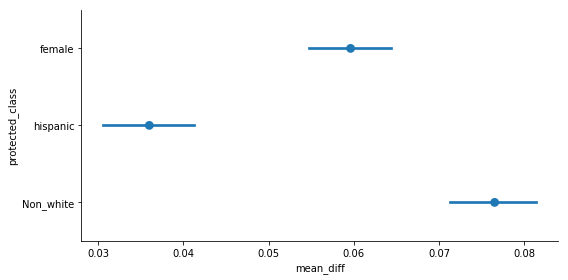

In [35]:
baseline_df = (
    experiment_baseline
    .query("fold_type == 'test' and estimator == 'LogisticRegression'")
)
sns.factorplot(y="protected_class", x="mean_diff", orient="h", data=baseline_df,
               size=4, aspect=2, join=False)

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


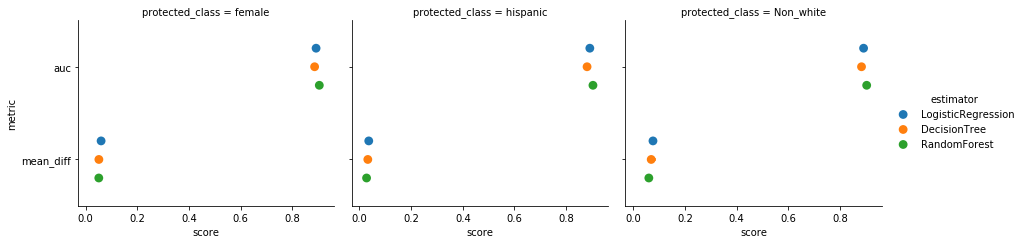

In [36]:
def plot_experiment_results(experiment_results):
    return (
        experiment_results
        .query("fold_type == 'test'")
        .drop(["fold_type", "cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["protected_class", "estimator"],
              var_name="metric", value_name="score")
        .pipe((sns.factorplot, "data"), y="metric",
              x="score", hue="estimator", col="protected_class", col_wrap=3,
              size=3.5, aspect=1.2, join=False, dodge=0.4))

plot_experiment_results(experiment_baseline);

In [37]:
from IPython.display import Markdown, display

def print_best_metrics(experiment_results, protected_classes):
    for pclass in protected_classes:
        msg = "#### protected class = %s:" % pclass
        display(Markdown(msg))
        exp_df = experiment_results[
            (experiment_results["protected_class"] == pclass) &
            (experiment_results["fold_type"] == "test")]
        msg = ""
        
        for m in UTILITY_METRICS:
            utility_msg = \
                "- best utility measured by %s (higher is better)" % m
            best_model = (
                exp_df
                .sort_values(m, ascending=False)
                .drop(["fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += utility_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        
        for m in FAIRNESS_METRICS:
            fairness_msg = \
                "- best fairness measured by %s (lower is better)" % m
            best_model = (
                exp_df
                # score closer to zero is better
                .assign(abs_measure=lambda df: df[m].abs())
                .sort_values("abs_measure")
                .drop(["abs_measure", "fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += fairness_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        display(Markdown(msg))
        
print_best_metrics(
    experiment_baseline_summary.reset_index(),
    ["female", "hispanic", "Non_white"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.905: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.051: RandomForest


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.904: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.028: RandomForest


#### protected class = Non_white:

- best utility measured by auc (higher is better) = 0.904: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.060: RandomForest


# Naive Fairness-aware Approach: Remove Protected Class

The naive approach to training fairness-aware models is to remove the protected class variables from the input data. While at face value this approach might seem like a good measure to prevent the model from learning the discriminatory patterns in the raw data, it doesn't preclude the possibility of other non-protected class variables highly correlate with protected class variables.

An well-known example of this is how zipcode correlates with race, so zipcode essentially serves as a proxy for race in the training data even if race is excluded from the input data.

In [38]:
# create feature sets that remove variables with protected class information
feature_set_no_sex = [f for f in feature_set_1 if f != "female"]
feature_set_no_ethnic = [f for f in feature_set_1 if f != "APP_ETH"]
feature_set_no_race = [
    f for f in feature_set_1 if
    f not in [
        'APP_RACE1_1.0',
        'APP_RACE1_2.0',
        'APP_RACE1_3.0',
        'APP_RACE1_4.0',
        'APP_RACE1_5.0']]

In [39]:
# training and target data
X_no_sex = df[feature_set_no_sex].values
X_no_ethnic = df[feature_set_no_ethnic].values
X_no_race = df[feature_set_no_race].values

experiment_naive_female = cross_validation_experiment(
    estimators, X_no_sex, y, s_female, "female")
experiment_naive_hispanic = cross_validation_experiment(
    estimators, X_no_ethnic, y, s_his, "hispanic")
experiment_naive_non_white = cross_validation_experiment(
    estimators, X_no_race, y, s_non_white, "non_white")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = hispanic
-------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = non_white
--------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14




In [40]:
experiment_naive = pd.concat([
    experiment_naive_female,
    experiment_naive_hispanic,
    experiment_naive_non_white
])
experiment_naive_summary = summarize_experiment_results(experiment_naive)
experiment_naive_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
female          DecisionTree       test       0.886144   0.045482
                LogisticRegression test       0.892179   0.059483
                RandomForest       test       0.904653   0.051622
hispanic        DecisionTree       test       0.886906   0.028689
                LogisticRegression test       0.891900   0.033584
                RandomForest       test       0.904247   0.026749
non_white       DecisionTree       test       0.891262   0.065326
                LogisticRegression test       0.890890   0.066261
                RandomForest       test       0.903790   0.058358

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


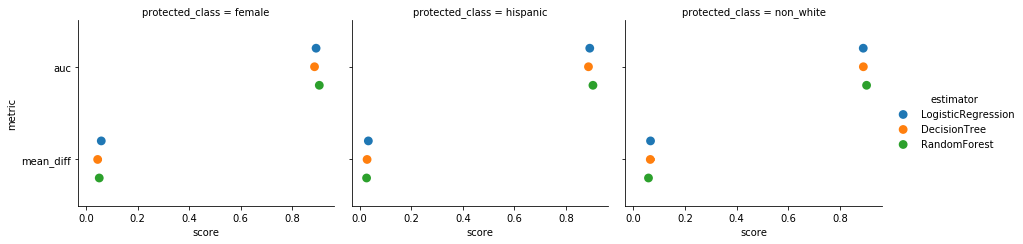

In [41]:
plot_experiment_results(experiment_naive);

In [42]:
print_best_metrics(
    experiment_naive_summary.reset_index(),
    ["female", "hispanic", "non_white"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.905: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.045: DecisionTree


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.904: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.027: RandomForest


#### protected class = non_white:

- best utility measured by auc (higher is better) = 0.904: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.058: RandomForest


## Fairness-aware Method: Relabelling

In [43]:
from sklearn.base import clone

from themis_ml.preprocessing.relabelling import Relabeller
from themis_ml.meta_estimators import FairnessAwareMetaEstimator

# here we use the relabeller class to create new y vectors for each of the
# protected class contexts.

# we also use the FairnessAwareMetaEstimator as a convenience class to
# compose together different fairness-aware methods. This wraps around the
# estimators that we defined in the previous
relabeller = Relabeller()
relabelling_estimators = [
    (name, FairnessAwareMetaEstimator(e, relabeller=relabeller))
    for name, e in estimators]

#X_no_sex X_no_ethnic X_no_race

experiment_relabel_female = cross_validation_experiment(
    relabelling_estimators, X_no_sex, y, s_female, "female")
experiment_relabel_hispanic = cross_validation_experiment(
    relabelling_estimators, X_no_ethnic, y, s_his, "hispanic")
experiment_relabel_Non_white = cross_validation_experiment(
    relabelling_estimators, X_no_race, y, s_non_white, "Non_white")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



RandomForest, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Training models: protected_class = hispanic
-------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



RandomForest, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Training models: protected_class = Non_white
--------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



RandomForest, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
experiment_relabel = pd.concat([
    experiment_relabel_female,
    experiment_relabel_hispanic,
    experiment_relabel_Non_white
])
experiment_relabel_summary = summarize_experiment_results(experiment_relabel)
experiment_relabel_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
Non_white       DecisionTree       test       0.879571   0.032985
                LogisticRegression test       0.883280   0.050887
                RandomForest       test       0.898522   0.028435
female          DecisionTree       test       0.881156   0.044952
                LogisticRegression test       0.886710   0.056745
                RandomForest       test       0.902037   0.048015
hispanic        DecisionTree       test       0.882737   0.038090
                LogisticRegression test       0.889256   0.038891
                RandomForest       test       0.903216   0.028807

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


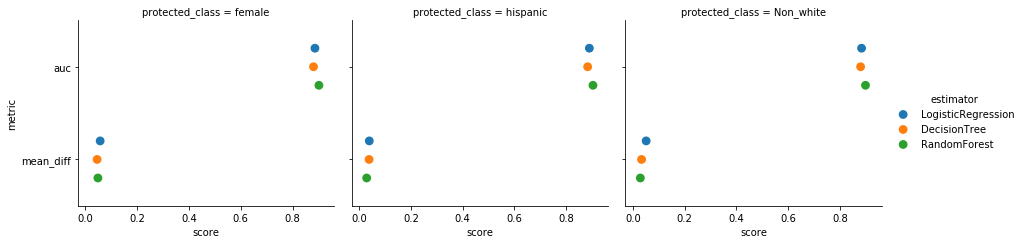

In [45]:
plot_experiment_results(experiment_relabel);

In [46]:
print_best_metrics(
    experiment_relabel_summary.reset_index(),
    ["female", "hispanic", "Non_white"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.902: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.045: DecisionTree


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.903: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.029: RandomForest


#### protected class = Non_white:

- best utility measured by auc (higher is better) = 0.899: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.028: RandomForest


# Validation Curve: Logistic Regression

In [47]:
LOGREG_L2_PARAM = [
    3, 1, 3e-1, 1e-1, 3e-2, 1e-2, 3e-3, 1e-3,
    3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8]

#X_no_sex X_no_ethnic X_no_race

def validation_curve_experiment(
        estimator_name, estimator, param_name, param_list, update_func):
    validaton_curve_experiment = []
    for param in param_list:
        e = clone(estimator)
        e = update_func(e, param_name, param)
        estimators = [(estimator_name, e)]
        experiment_relabel_female = cross_validation_experiment(
            estimators, X_no_sex, y, s_female, "female",
            verbose=False)
        experiment_relabel_hispanic = cross_validation_experiment(
            estimators, X_no_ethnic, y, s_his, "hispanic",
            verbose=False)
        experiment_relabel_Non_white = cross_validation_experiment(
            estimators, X_no_race, y, s_non_white, "Non_white",
            verbose=False)
        validaton_curve_experiment.extend(
            [experiment_relabel_female.assign(**{param_name: param}),
             experiment_relabel_hispanic.assign(**{param_name: param}),
             experiment_relabel_Non_white.assign(**{param_name: param})])
    return pd.concat(validaton_curve_experiment)


def update_relabeller(e, param_name, param):
    e = clone(e)
    child_estimator = clone(e.estimator)
    child_estimator.set_params(**{param_name: param})
    e.set_params(estimator=child_estimator)
    return e
        

relabel_validaton_curve_experiment = validation_curve_experiment(
    "LogisticRegression", FairnessAwareMetaEstimator(
        LOGISTIC_REGRESSION, relabeller=Relabeller()),
    "C", LOGREG_L2_PARAM, update_relabeller)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


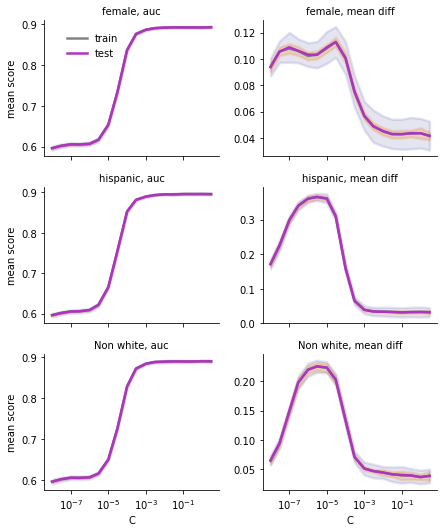

In [48]:
def validation_curve_plot(x, y, **kwargs):
    ax = plt.gca()
    lw = 2.5
    data = kwargs.pop("data")
    train_data = data.query("fold_type == 'train'")
    test_data = data.query("fold_type == 'test'")
    grp_data_train = train_data.groupby(x)
    grp_data_test = test_data.groupby(x)
    mean_data_train = grp_data_train[y].mean()
    mean_data_test = grp_data_test[y].mean()
    std_data_train = grp_data_train[y].std()
    std_data_test = grp_data_test[y].std()
    ax.semilogx(mean_data_train.index, mean_data_train,
                label="train", color="#848484", lw=lw)
    ax.semilogx(mean_data_test.index, mean_data_test,
                label="test", color="#ae33bf", lw=lw)
    # # Add error region
    ax.fill_between(mean_data_train.index, mean_data_train - std_data_train,
                    mean_data_train + std_data_train, alpha=0.2,
                    color="darkorange", lw=lw)
    ax.fill_between(mean_data_test.index, mean_data_test - std_data_test,
                    mean_data_test + std_data_test, alpha=0.1,
                    color="navy", lw=lw)

relabel_validaton_curve_experiment_df = (
    relabel_validaton_curve_experiment
    .pipe(pd.melt,
          id_vars=["protected_class", "estimator", "cv_fold", "fold_type",
                   "C"],
          value_vars=["auc", "mean_diff"],
          var_name="metric", value_name="score")
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
        metric=lambda df: df.metric.str.replace("_", " "))
    .rename(columns={"score": "mean score"})
)

# relabel_validaton_curve_experiment_df
g = sns.FacetGrid(
    relabel_validaton_curve_experiment_df,
    row="protected_class",
    col="metric", size=2.5, aspect=1.1, sharey=False,
    margin_titles=False)
g = g.map_dataframe(validation_curve_plot, "C", "mean score")
g.set_titles(template="{row_name}, {col_name}")
# g.add_legend()
# g.add_legend(bbox_to_anchor=(0.275, 0.91))
g.add_legend(bbox_to_anchor=(0.28, 0.9))
g.fig.tight_layout()

# Fairness-aware Method: Additive Counterfactually Fair Model

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from themis_ml.linear_model.counterfactually_fair_models import \
    LinearACFClassifier

import warnings
warnings.filterwarnings('ignore')

def cross_validation_experiment_2(estimators, X, y, s, s_name, verbose=True):
    msg = "Training models: protected_class = %s" % s_name
    if verbose:
        print(msg)
        print("-" * len(msg))
    performance_scores = []
    # stratified groups tries to balance out y and s
    groups = [i + j for i, j in
              zip(y.astype(str), s_female.astype(str))]
    cv = RepeatedStratifiedKFold(
        #n_splits=N_SPLITS,
        #n_repeats=N_REPEATS,
        #random_state=RANDOM_STATE)
        n_splits=2,
        n_repeats=3,
        random_state=1000)
    for e_name, e in estimators:
        if verbose:
            print("%s, fold:" % e_name),
        for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
            if verbose:
                print(i),
            # create train and validation fold partitions
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            s_train, s_test = s[train], s[test]

            # fit model and generate train and test predictions            
            #train_pred_prob = e.fit(X_train, y_train, s_train).predict_proba(X_train, s_train)[:, 1]
            train_pred = e.fit(X_train, y_train, s_train).predict(X_train, s_train)
            #train_pred_prob = e.fit(X_train, y_train, s_train).predict_proba(X_test, s_test)[:, 1]
            test_pred = e.fit(X_train, y_train, s_train).predict(X_test, s_test)
            
            # train scores
            performance_scores.append([
                s_name, e_name, i, "train",
                # regular metrics
                roc_auc_score(y_train, train_pred),

                # fairness metrics
                mean_difference(train_pred, s_train)[0],
            ])
            # test scores
            performance_scores.append([
                s_name, e_name, i, "test",
                # regular metrics
                roc_auc_score(y_test, test_pred),
                # fairness metrics
                mean_difference(test_pred, s_test)[0]])
        if verbose:
            print("")
    if verbose:
        print("")
    return pd.DataFrame(
        performance_scores,
        columns=[
            "protected_class", "estimator", "cv_fold", "fold_type",
            "auc", "mean_diff"])

LOGISTIC_REGRESSION = LogisticRegression(
    penalty="l2", C=0.001, class_weight="balanced")
DECISION_TREE_CLF = DecisionTreeClassifier(
    criterion="entropy", max_depth=10, min_samples_leaf=10, max_features=10,
    class_weight="balanced")
RANDOM_FOREST_CLF = RandomForestClassifier(
    criterion="entropy", n_estimators=50, max_depth=10, max_features=10,
    min_samples_leaf=10, class_weight="balanced",n_jobs=-1)
estimators = [
    ("LogisticRegression", LOGISTIC_REGRESSION),
    ("DecisionTree", DECISION_TREE_CLF),
    ("RandomForest", RANDOM_FOREST_CLF)
]

# use the estimators defined above to define the linear additive
# counterfactually fair models
linear_acf_estimators = [
    (name, LinearACFClassifier(
         target_estimator=e,
         binary_residual_type="absolute"))
    for name, e in estimators]


experiment_acf_female = cross_validation_experiment_2(
    linear_acf_estimators, X_no_sex, y, s_female, "female")
experiment_acf_hispanic = cross_validation_experiment_2(
    linear_acf_estimators, X_no_ethnic, y, s_his, "hispanic")
experiment_acf_Non_white = cross_validation_experiment_2(
    linear_acf_estimators, X_no_race, y, s_non_white, "Non_white")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold:
0
1
2
3
4
5

DecisionTree, fold:
0
1
2
3
4
5

RandomForest, fold:
0
1
2
3
4
5


Training models: protected_class = hispanic
-------------------------------------------
LogisticRegression, fold:
0
1
2
3
4
5

DecisionTree, fold:
0
1
2
3
4
5

RandomForest, fold:
0
1
2
3
4
5


Training models: protected_class = Non_white
--------------------------------------------
LogisticRegression, fold:
0
1
2
3
4
5

DecisionTree, fold:
0
1
2
3
4
5

RandomForest, fold:
0
1
2
3
4
5




In [75]:
experiment_acf = pd.concat([
    experiment_acf_female,
    experiment_acf_hispanic,
    experiment_acf_Non_white
])
experiment_acf_summary = summarize_experiment_results(experiment_acf)
experiment_acf_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
Non_white       DecisionTree       test       0.832031   0.064778
                LogisticRegression test       0.837321   0.026687
                RandomForest       test       0.840172   0.073856
female          DecisionTree       test       0.831767   0.064946
                LogisticRegression test       0.838130   0.031203
                RandomForest       test       0.840140   0.052334
hispanic        DecisionTree       test       0.824895   0.046390
                LogisticRegression test       0.838361   0.013097
                RandomForest       test       0.840363   0.039158

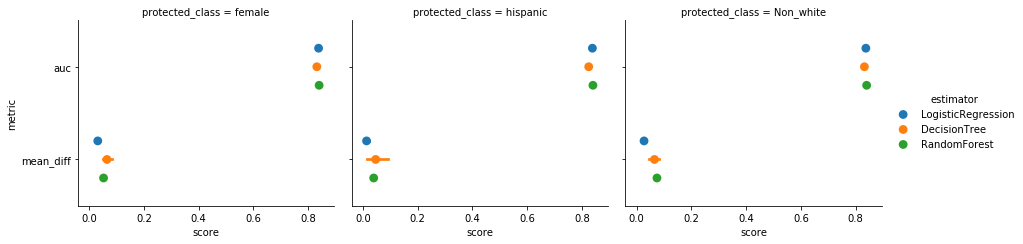

In [76]:
plot_experiment_results(experiment_acf);

In [77]:
print_best_metrics(
    experiment_acf_summary.reset_index(),
    ["female", "hispanic", "Non_white"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.840: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.031: LogisticRegression


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.840: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.013: LogisticRegression


#### protected class = Non_white:

- best utility measured by auc (higher is better) = 0.840: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.027: LogisticRegression


# Fairness-aware Method: Reject-option Classification

In [60]:
from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier

# use the estimators defined above to define the linear additive
# counterfactually fair models
single_roc_clf_estimators = [
    (name, SingleROClassifier(estimator=e))
    for name, e in estimators]

#X_no_sex X_no_ethnic X_no_race

experiment_single_roc_female = cross_validation_experiment(
    single_roc_clf_estimators, X_no_sex, y, s_female, "female")
experiment_single_roc_hispanic = cross_validation_experiment(
    single_roc_clf_estimators, X_no_ethnic, y, s_his, "hispanic")
experiment_single_roc_Non_white = cross_validation_experiment(
    single_roc_clf_estimators, X_no_race, y, s_non_white, "Non_white")


Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = hispanic
-------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Training models: protected_class = Non_white
--------------------------------------------
LogisticRegression, fold:
0


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


12


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


13


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


14


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



DecisionTree, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

RandomForest, fold:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14




In [61]:
experiment_single_roc  = pd.concat([
    experiment_single_roc_female,
    experiment_single_roc_hispanic,
    experiment_single_roc_Non_white
])
experiment_single_roc_summary = summarize_experiment_results(
    experiment_single_roc)
experiment_single_roc_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
Non_white       DecisionTree       test       0.885611   0.071202
                LogisticRegression test       0.889115   0.072963
                RandomForest       test       0.903082   0.075403
female          DecisionTree       test       0.883617   0.049040
                LogisticRegression test       0.890381   0.062221
                RandomForest       test       0.903361   0.053690
hispanic        DecisionTree       test       0.881697   0.042798
                LogisticRegression test       0.890083   0.057149
                RandomForest       test       0.903488   0.045533

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


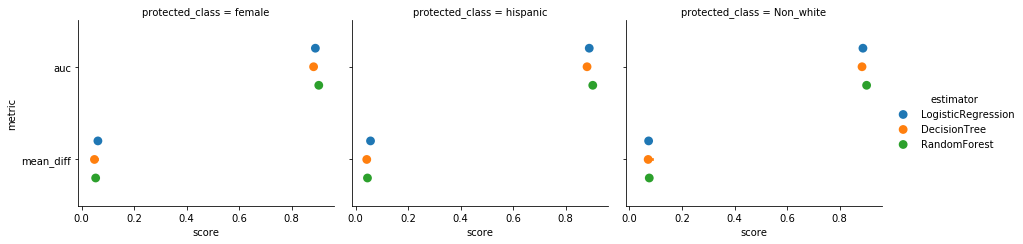

In [62]:
plot_experiment_results(experiment_single_roc);

In [63]:
print_best_metrics(
    experiment_single_roc_summary.reset_index(),
    ["female", "hispanic", "Non_white"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.903: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.049: DecisionTree


#### protected class = hispanic:

- best utility measured by auc (higher is better) = 0.903: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.043: DecisionTree


#### protected class = Non_white:

- best utility measured by auc (higher is better) = 0.903: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.071: DecisionTree


# Comparison of Fairness-aware Techniques

In [78]:
compare_experiments = (
    pd.concat([
        experiment_baseline.assign(experiment="B"),
        experiment_relabel.assign(experiment="RTV"),
        experiment_acf.assign(experiment="CFM"),
        experiment_single_roc.assign(experiment="ROC")
    ])
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
    )
)
compare_experiments.head()

,protected_class,estimator,cv_fold,fold_type,auc,mean_diff,experiment
0,female,LogisticRegression,0,train,0.892804,0.055431,B
1,female,LogisticRegression,0,test,0.892562,0.060039,B
2,female,LogisticRegression,1,train,0.891534,0.067258,B
3,female,LogisticRegression,1,test,0.894895,0.050919,B
4,female,LogisticRegression,2,train,0.892389,0.056731,B


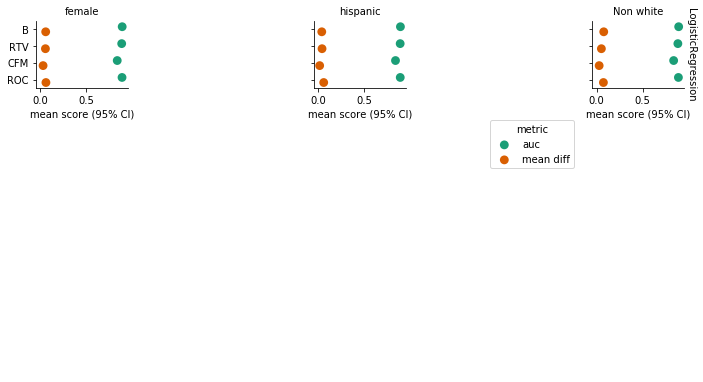

In [79]:
comparison_palette = sns.color_palette("Dark2", n_colors=8)

def compare_experiment_results_multiple_model(experiment_results):
    g = (
        experiment_results
        .query("fold_type == 'test'")
        .drop(["cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["experiment", "protected_class", "estimator",
                                "fold_type"],
              var_name="metric", value_name="score")
        .assign(
            metric=lambda df: df.metric.str.replace("_", " "))
        .pipe((sns.factorplot, "data"), y="experiment",
              x="score", hue="metric",
              col="protected_class", row="estimator",
              join=False, size=3, aspect=1.1, dodge=0.3,
              palette=comparison_palette, margin_titles=True, legend=False))
    g.set_axis_labels("mean score (95% CI)")
    for ax in g.axes.ravel():
        ax.set_ylabel("")
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    plt.legend(title="metric", loc=9, bbox_to_anchor=(-0.65, -0.4))
    g.fig.legend(loc=9, bbox_to_anchor=(0.5, -0.3))
    g.fig.tight_layout()

compare_experiment_results_multiple_model(
    compare_experiments.query("estimator == 'LogisticRegression'"));

In [80]:

from scipy import stats

def compute_corr_pearson(x, y, ci=0.95):
    corr = stats.pearsonr(x, y)
    z = np.arctanh(corr[0])
    sigma = (1 / ((len(x) - 3) ** 0.5))
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1 + ci ) / 2)
    return corr, np.tanh(cint)

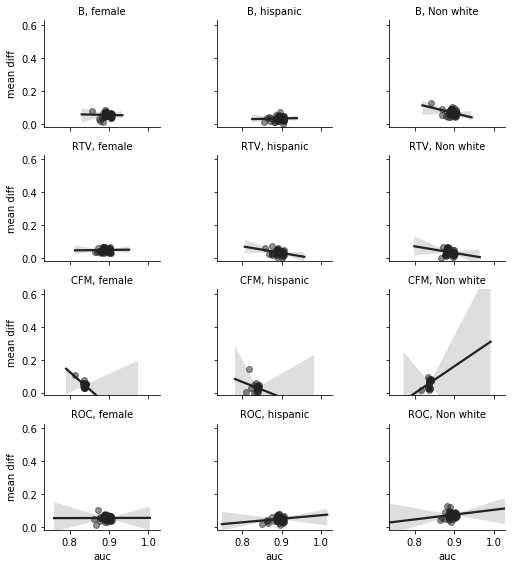

In [81]:
black_palette = sns.color_palette(["#222222"])

def plot_utility_fairness_tradeoff(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    sns_ax = sns.regplot(x=x, y=y, data=data, scatter_kws={'alpha':0.5},
                         **kwargs)
    (corr, p_val), ci = compute_corr_pearson(data[x], data[y])
    r_text = 'r = %0.02f (%0.02f, %0.02f)' % \
        (corr, ci[0], ci[1])
    sns_ax.annotate(
        r_text, xy=(0.7, 0),
        xytext=(0.07, 0.91),
        textcoords='axes fraction',
        fontweight="bold",
        fontsize=9,
        color="gray"
    )
    bottom_padding = 0.05
    top_padding = 0.5
    ylim = (data[y].min() - bottom_padding, data[y].max() + top_padding)
    sns_ax.set_ylim(*ylim)


g = sns.FacetGrid(
    (
        compare_experiments
        .drop("cv_fold", axis=1)
        .reset_index()
        .query("fold_type == 'test'")
        .rename(
            columns={"mean_diff": "mean diff"})
    ),
    col="protected_class",
    row="experiment",
    hue="experiment",
    size=2.0, aspect=1.3, sharey=True,
    palette=black_palette)
g.map_dataframe(plot_utility_fairness_tradeoff, "auc", "mean diff")
g.set_titles(template="{row_name}, {col_name}")
g.fig.tight_layout()

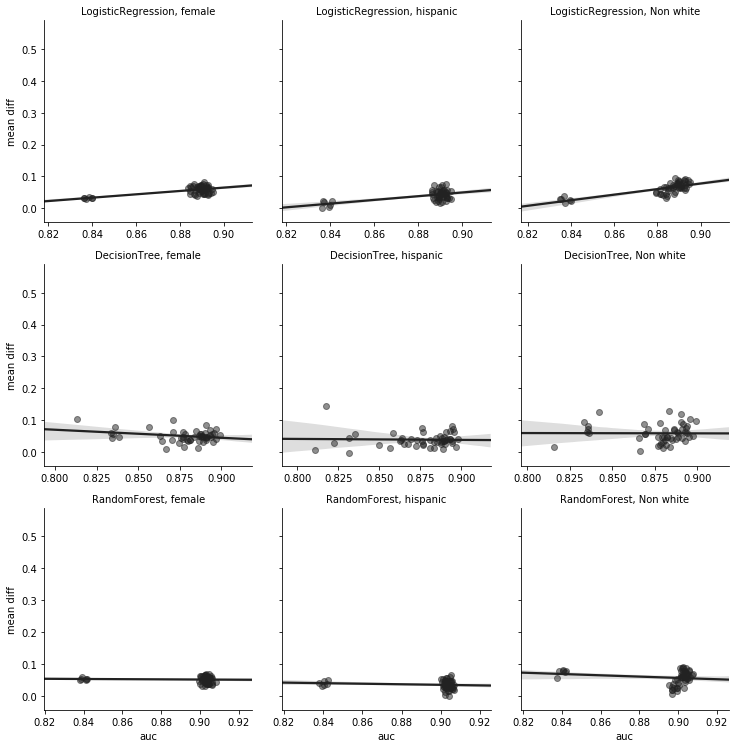

In [82]:
g = sns.FacetGrid(
    (
        compare_experiments
        .drop("cv_fold", axis=1)
        .reset_index()
        .query("fold_type == 'test'")
        .rename(
            columns={"mean_diff": "mean diff"})
    ),
    col="protected_class",
    row="estimator",
    hue="estimator",
    size=3.5, aspect=1,
    sharey=True, sharex=False,
    palette=black_palette)
g.map_dataframe(plot_utility_fairness_tradeoff, "auc", "mean diff")
g.set_titles(template="{row_name}, {col_name}")
g.fig.tight_layout()